# Solve observable tica on X and Y

In [106]:
import numpy as np
from scipy.linalg import solve_discrete_lyapunov
from sklearn import decomposition
import matplotlib.pyplot as plt
%matplotlib inline
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories
from matplotlib import cm
from pyemma.coordinates import tica

from msmbuilder.featurizer import AtomPairsFeaturizer
pairs = []
for i in range(22):
    for j in range(i):
        pairs.append((j,i))
X = AtomPairsFeaturizer(pairs).fit_transform(trajs)

from msmbuilder.featurizer import DihedralFeaturizer
Y = DihedralFeaturizer().fit_transform(trajs)
Y_di = np.array(DihedralFeaturizer(sincos=False).fit_transform(trajs))

lag = 1

epsilon = .05

X_pca = decomposition.PCA(whiten=True, n_components = 1-epsilon)
X_pca.fit(np.vstack(X))
X_whitened = [X_pca.transform(x) for x in X]


X_0_trajstructure = [x[:-lag] for x in X_whitened]

X_0 = np.vstack([x[:-lag] for x in X_whitened])
X_tau = np.vstack([x[lag:] for x in X_whitened])

X_0 = np.insert(X_0, len(X_0[0]), 1, axis=1)
X_tau = np.insert(X_tau, len(X_tau[0]), 1, axis=1)

K_xx_tuple = np.linalg.lstsq(X_0, X_tau)
K_xx = K_xx_tuple[0]

Y_pca = decomposition.PCA(whiten=True, n_components = 1-epsilon)
Y_pca.fit(np.vstack(Y))
Y_whitened = [Y_pca.transform(y) for y in Y]

Y_0 = np.vstack([y[:-lag] for y in Y_whitened])
Y_tau = np.vstack([y[lag:] for y in Y_whitened])
                  
Y_0 = np.insert(Y_0, len(Y_0[0]), 1, axis=1)
Y_tau = np.insert(Y_tau, len(Y_tau[0]), 1, axis=1)

K_xy_tuple = np.linalg.lstsq(X_0, Y_tau)
K_xy = K_xy_tuple[0]

s = np.linalg.svd(K_xy, compute_uv=False)


alanine_dipeptide already is cached


In [107]:
print(np.linalg.eigvalsh(K_xx))
v_x = np.linalg.eigh(K_xx)[1][-1]
chi_bar = np.vstack(X_whitened).mean(0)
gamma_bar = np.vstack(Y_whitened).mean(0)

print(len(chi_bar))

chi_bar = np.insert(chi_bar, len(chi_bar), 1)
gamma_bar = np.insert(gamma_bar, len(gamma_bar), 1)

print(len(chi_bar))


A = K_xx - np.outer(v_x, chi_bar)
B = K_xy - np.outer(v_x, gamma_bar)

Q = np.dot(B, B.T)


[ 0.02267283  0.07553721  0.39503404  0.40251571  0.44162381  0.44733649
  0.50909871  0.51396203  0.59758002  0.7745344   0.87356305  0.88818842
  0.92832559  0.93591678  0.98246032  1.00000083]
15
16


In [108]:
O = solve_discrete_lyapunov(A, Q)


In [109]:
u, s, v = np.linalg.svd(O)


In [110]:
X_transformed = np.dot(X_0, u)


# Solve regular tica on X and Y independently

In [111]:
obj_x = tica(np.vstack(X), lag = 1, dim = 2).get_output()[0]
obj_x = np.array(obj_x)

In [112]:
obj_y = tica(np.vstack(Y), lag = 1, dim = 2).get_output()[0]
obj_y = np.array(obj_y)

# Measuring the correlation between Obs_tic0, Obs_tic1, X_tic0, X_tic1, Y_tic0, Y_tic1

In [102]:
obs_tic0 = X_transformed[:,0]
obs_tic1 = X_transformed[:,1]
x_tic0 = obj_x.T[0]
x_tic1 = obj_x.T[1]
y_tic0 = obj_y.T[0]
y_tic1 = obj_y.T[1]

print (len(obs_tic0), len(obs_tic1), len(x_tic0), len(x_tic1), len(y_tic0), len(y_tic1))

99989 99989 99999 99999 99999 99999


In [119]:
a = [obs_tic0, obs_tic1, x_tic0[:99989], x_tic1[:99989], y_tic0[:99989], y_tic1[:99989]]
a_names = ['obs_tic0', 'obs_tic1', 'x_tic0', 'x_tic1', 'y_tic0', 'y_tic1']

corr = np.identity(6)
# np.cov(a, rowvar = False)
for i in range(len(a)):
    for j in range(i):
        corr_mat = np.corrcoef(a[j], a[i])
#         print (corr_mat, (a_names[j], a_names[i]))
        corr[i][j] = corr_mat[0][1]
        corr[j][i] = corr_mat[0][1]
print ('\n')
print (a_names)
print (corr)




['obs_tic0', 'obs_tic1', 'x_tic0', 'x_tic1', 'y_tic0', 'y_tic1']
[[  1.00000000e+00  -4.41117628e-05  -9.70876417e-01  -3.47315826e-03
   -9.69997071e-01  -6.42954740e-03]
 [ -4.41117628e-05   1.00000000e+00  -7.87191299e-03   6.27452267e-02
   -1.24458513e-02   4.75248716e-01]
 [ -9.70876417e-01  -7.87191299e-03   1.00000000e+00  -9.33791480e-05
    9.98384335e-01   9.24188633e-03]
 [ -3.47315826e-03   6.27452267e-02  -9.33791480e-05   1.00000000e+00
   -1.88040797e-03   4.96049922e-02]
 [ -9.69997071e-01  -1.24458513e-02   9.98384335e-01  -1.88040797e-03
    1.00000000e+00   1.18568888e-04]
 [ -6.42954740e-03   4.75248716e-01   9.24188633e-03   4.96049922e-02
    1.18568888e-04   1.00000000e+00]]


# REGULAR tica alanine dipeptide trajectories plotted with dihedral angle colormap

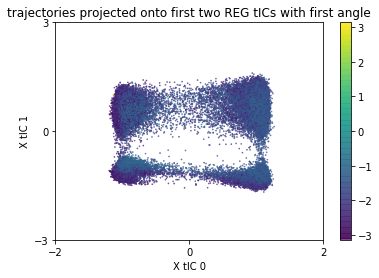

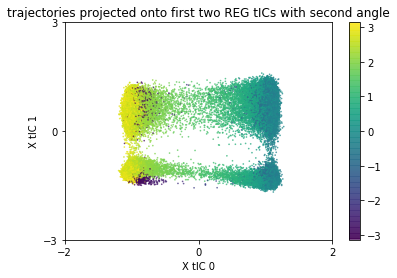

In [122]:
di_reg_tica = np.vstack(Y_di)
di_reg_tica = np.array(di_reg_tica)

plt.scatter(obj_x.T[0], obj_x.T[1], s=0.5, alpha=0.7, c=di_reg_tica.T[0], cmap=cm.viridis)

plt.xlabel('X tIC 0')
plt.ylabel('X tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
label = 'trajectories projected onto first two REG tICs with first angle'
plt.title(label)

plt.colorbar()
plt.show()


plt.scatter(obj_x.T[0], obj_x.T[1], s=0.5, alpha=0.7, c=di_reg_tica.T[1], cmap=cm.viridis)

plt.xlabel('X tIC 0')
plt.ylabel('X tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
label = 'trajectories projected onto first two REG tICs with second angle'
plt.title(label)

plt.colorbar()
plt.show()


# OBSERVABLE tica alanine dipeptide trajectories plotted with dihedral angle colormap

99989
(99989, 2)


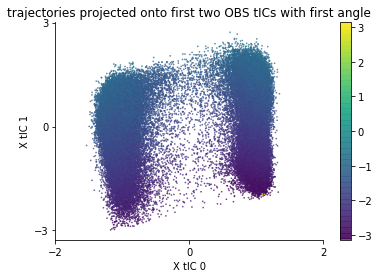

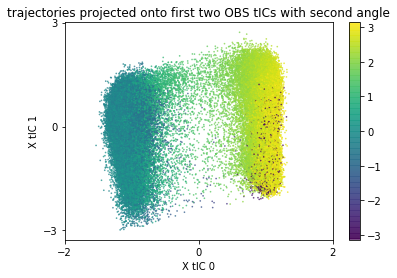

In [121]:
angles = []
for i in range(len(X_0_trajstructure)):
    angles.append(Y_di[i][:len(X_0_trajstructure[i])])
angles = np.vstack(angles)
angles = np.array(angles)
print (len(obs_tic0))
print(np.array(angles).shape)
ax = plt.subplot(111)
plt.scatter(obs_tic0, obs_tic1, s=0.5, alpha=0.7, c=angles.T[0], cmap=cm.viridis)

plt.xlabel('X tIC 0')
plt.ylabel('X tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
label = 'trajectories projected onto first two OBS tICs with first angle'
plt.title(label)

plt.colorbar()
plt.show()


plt.scatter(obs_tic0, obs_tic1, s=0.5, alpha=0.7, c=angles.T[1], cmap=cm.viridis)

plt.xlabel('X tIC 0')
plt.ylabel('X tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
label = 'trajectories projected onto first two OBS tICs with second angle'
plt.title(label)

plt.colorbar()
plt.show()


# the rest is nothing

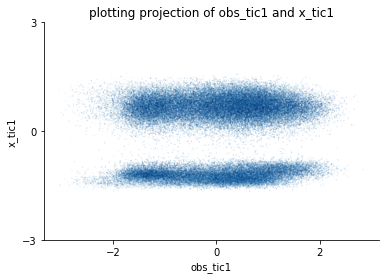

In [49]:
def make_plot(i,j):
    ax = plt.subplot(111)
    plt.scatter(a[i],a[j], c=range(len(X_transformed[:,0])), cmap=cm.Blues, s=.01,alpha=0.75)
    plt.xlabel(a_names[i])
    plt.ylabel(a_names[j])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks([-2,0,2])
    plt.yticks([-3,0,3])
    label = 'plotting projection of '+a_names[i]+ ' and '+a_names[j]
    plt.title(label)
make_plot(1,3)

# Graphing regular tica with color map for phi and psi angles

0 9999
_______________________________________________________


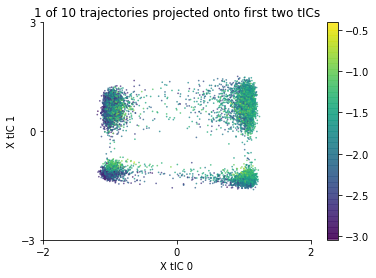

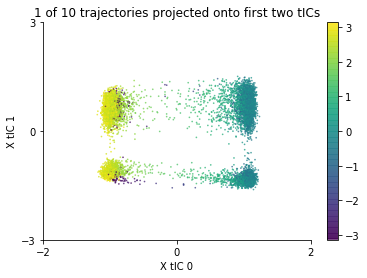

9999 19999
_______________________________________________________


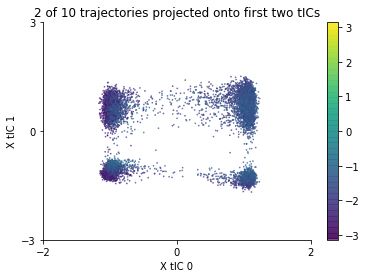

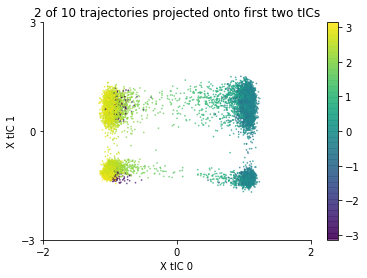

19999 29999
_______________________________________________________


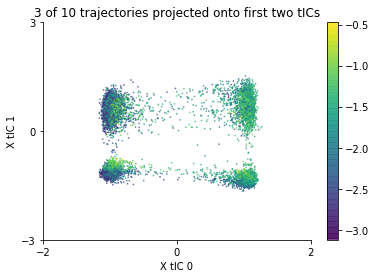

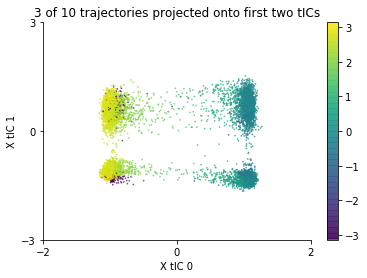

29999 39999
_______________________________________________________


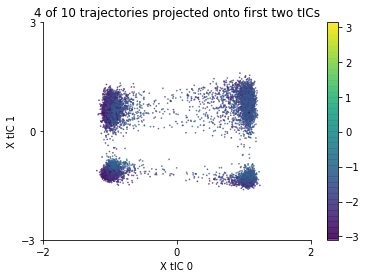

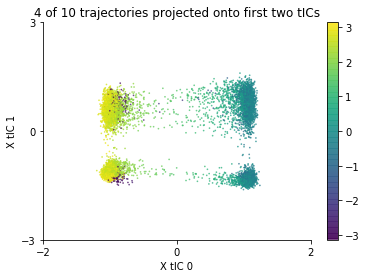

39999 49999
_______________________________________________________


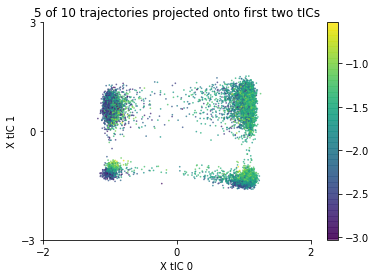

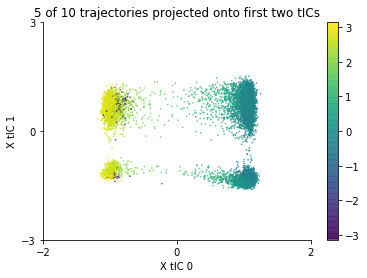

49999 59999
_______________________________________________________


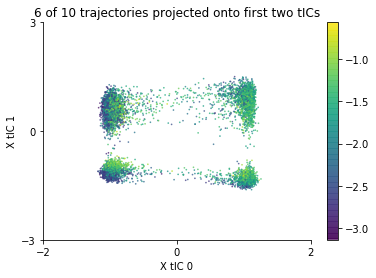

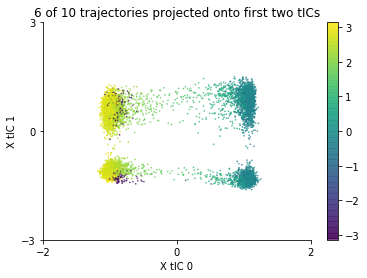

59999 69999
_______________________________________________________


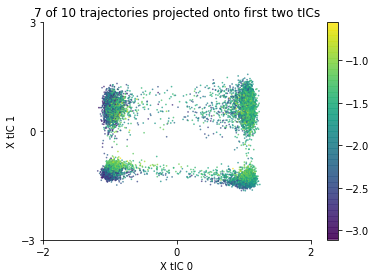

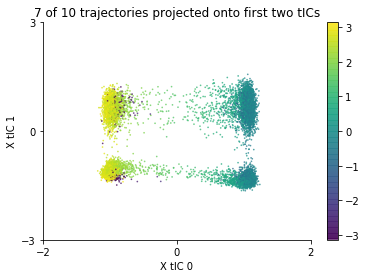

69999 79999
_______________________________________________________


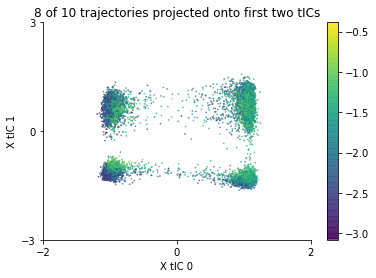

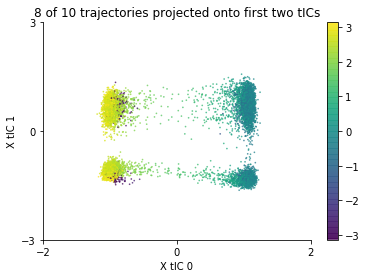

79999 89999
_______________________________________________________


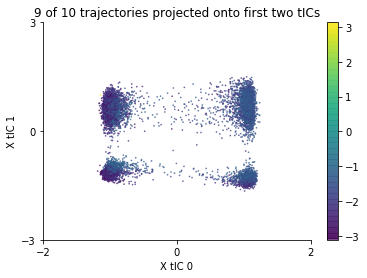

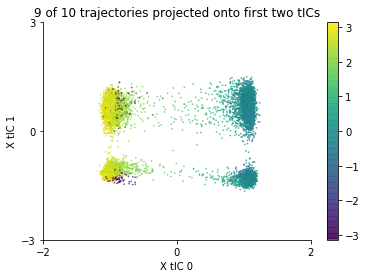

89999 99999
_______________________________________________________


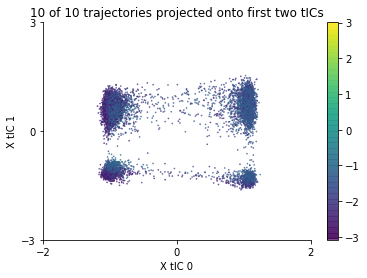

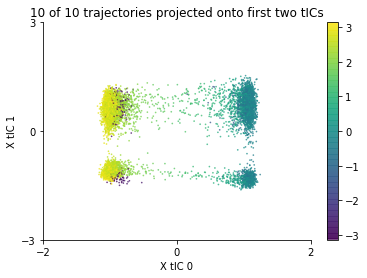

In [50]:
obj_x = obj_x.T
starting_idx = 0
ending_idx = 0
for i in range(len(X)):
    ending_idx += len(X[i])
#     print(starting_idx, ending_idx, ending_idx - starting_idx)
    x_coors = obj_x[0][starting_idx:ending_idx]
    y_coors = obj_x[1][starting_idx:ending_idx]
    di_angles = Y_di[i]
    print (starting_idx, ending_idx)
    print ('_______________________________________________________')
    for j in range(2):
#         print (len(di_angles.T[j]), len(x_coors))
        assert len(di_angles.T[j])==len(x_coors), 'not the same number of points for the angles as the plotting traj points:'



        ax = plt.subplot(111)
        plt.scatter(x_coors, y_coors, s=0.5, alpha=0.7, c=di_angles.T[j], cmap=cm.viridis)
        plt.xlabel('X tIC 0')
        plt.ylabel('X tIC 1')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.xticks([-2,0,2])
        plt.yticks([-3,0,3])
        label = str(i+1)+' of '+str(len(X)) +' trajectories projected onto first two tICs'
        plt.title(label)
        
        plt.colorbar()
        plt.show()
    starting_idx = ending_idx


# Graphing observable tica with dihedral angles colormapped

10000
_______________________________________________________


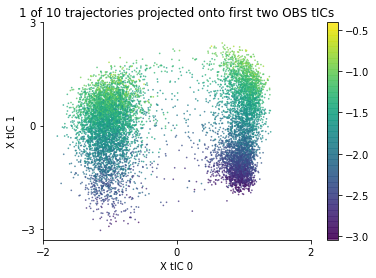

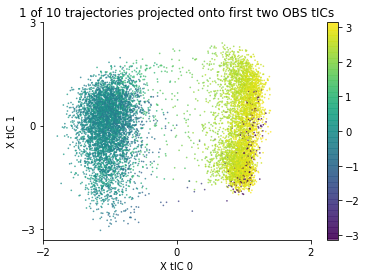

_______________________________________________________


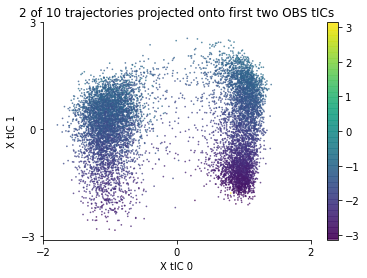

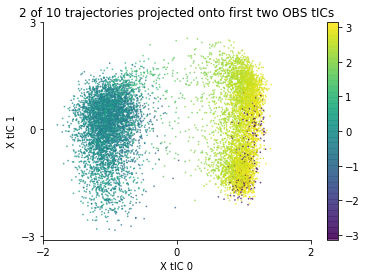

_______________________________________________________


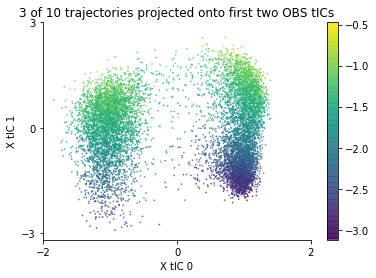

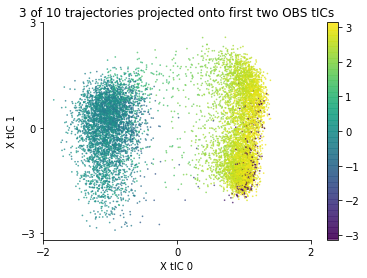

_______________________________________________________


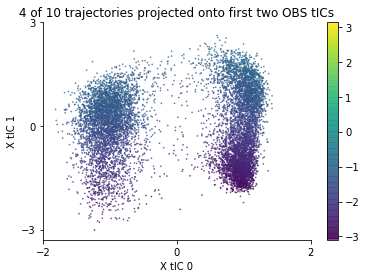

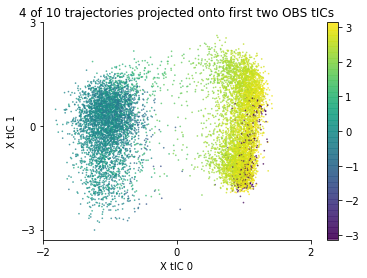

_______________________________________________________


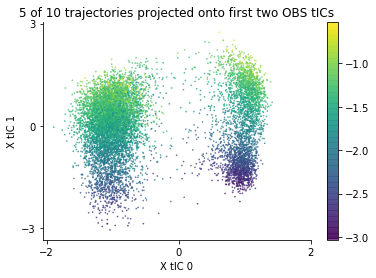

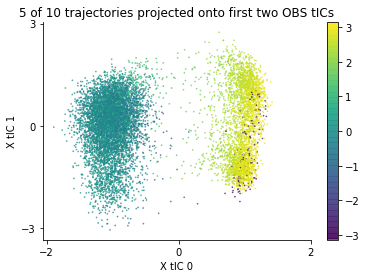

_______________________________________________________


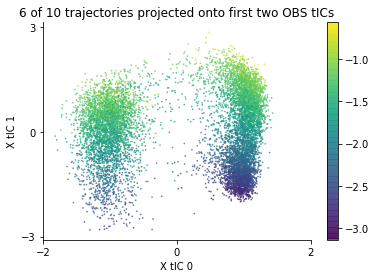

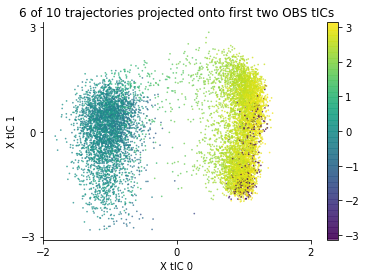

_______________________________________________________


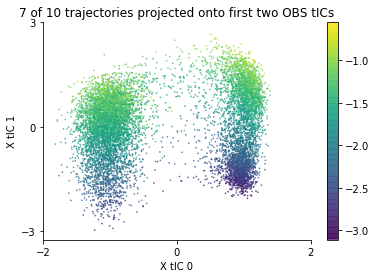

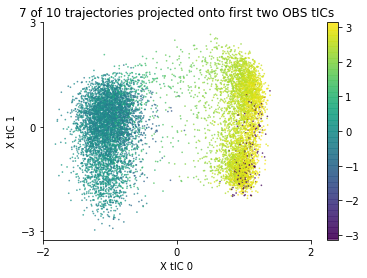

_______________________________________________________


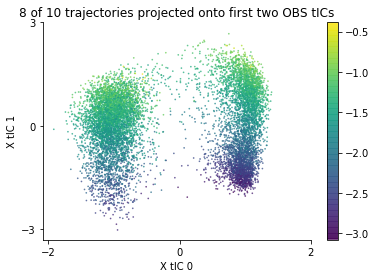

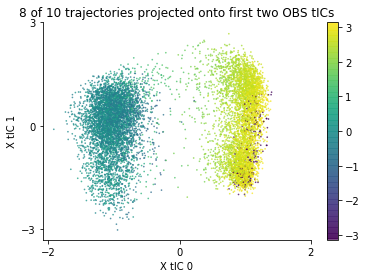

_______________________________________________________


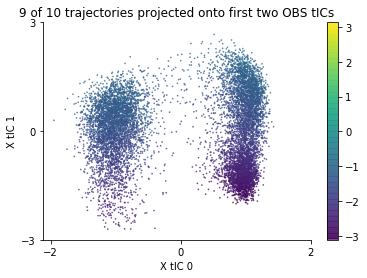

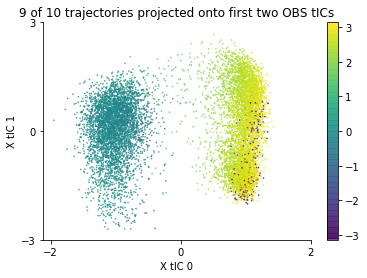

_______________________________________________________


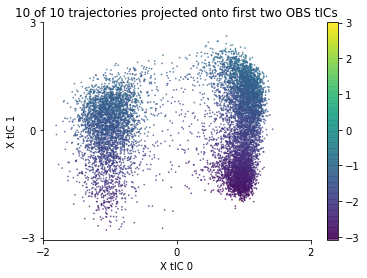

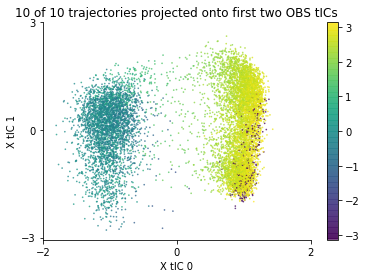

In [80]:
print(len(Y_di[1]))
obj_x = obj_x.T
starting_idx = 0
ending_idx = 0
for i in range(len(X_0_trajstructure)):
    ending_idx += len(X_0_trajstructure[i])
    
#     print(starting_idx, ending_idx, ending_idx - starting_idx)
    x_coors = obs_tic0[starting_idx:ending_idx]
    y_coors = obs_tic1[starting_idx:ending_idx]
    di_angles = Y_di[i][:len(X_0_trajstructure[i])]

    print ('_______________________________________________________')
    
    for j in range(2):
        assert len(di_angles.T[j])==len(x_coors), 'not the same number of points for the angles as the plotting traj points:'



        ax = plt.subplot(111)
        plt.scatter(x_coors, y_coors, s=0.5, alpha=0.7, c=di_angles.T[j], cmap=cm.viridis)
        plt.xlabel('X tIC 0')
        plt.ylabel('X tIC 1')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.xticks([-2,0,2])
        plt.yticks([-3,0,3])
        label = str(i+1)+' of '+str(len(X)) +' trajectories projected onto first two OBS tICs'
        plt.title(label)
        
        plt.colorbar()
        plt.show()
    starting_idx = ending_idx


99989
(99989, 2)


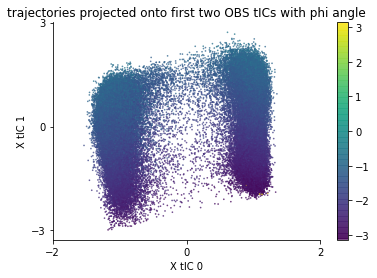

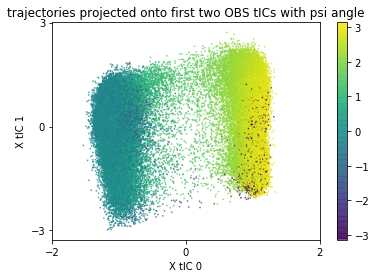

In [104]:
angles = []
for i in range(len(X_0_trajstructure)):
    angles.append(Y_di[i][:len(X_0_trajstructure[i])])
angles = np.vstack(angles)
angles = np.array(angles)
print (len(obs_tic0))
print(np.array(angles).shape)
ax = plt.subplot(111)
plt.scatter(obs_tic0, obs_tic1, s=0.5, alpha=0.7, c=angles.T[0], cmap=cm.viridis)

plt.xlabel('X tIC 0')
plt.ylabel('X tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
label = 'trajectories projected onto first two OBS tICs with phi angle'
plt.title(label)

plt.colorbar()
plt.show()


plt.scatter(obs_tic0, obs_tic1, s=0.5, alpha=0.7, c=angles.T[1], cmap=cm.viridis)

plt.xlabel('X tIC 0')
plt.ylabel('X tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
label = 'trajectories projected onto first two OBS tICs with psi angle'
plt.title(label)

plt.colorbar()
plt.show()


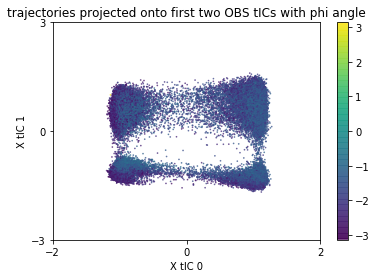

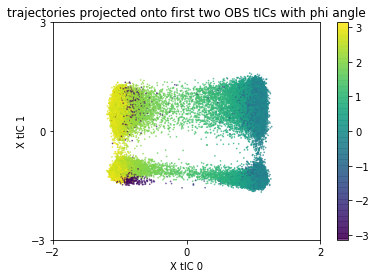

In [116]:
di_reg_tica = np.vstack(Y_di)
di_reg_tica = np.array(di_reg_tica)

plt.scatter(obj_x.T[0], obj_x.T[1], s=0.5, alpha=0.7, c=di_reg_tica.T[0], cmap=cm.viridis)

plt.xlabel('X tIC 0')
plt.ylabel('X tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
label = 'trajectories projected onto first two OBS tICs with phi angle'
plt.title(label)

plt.colorbar()
plt.show()


plt.scatter(obj_x.T[0], obj_x.T[1], s=0.5, alpha=0.7, c=di_reg_tica.T[1], cmap=cm.viridis)

plt.xlabel('X tIC 0')
plt.ylabel('X tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
label = 'trajectories projected onto first two OBS tICs with phi angle'
plt.title(label)

plt.colorbar()
plt.show()
